Data Augmentation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


Dataset load

In [4]:
 # full training data
full_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=train_transform
)

# official test data
test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=test_transform
)

# split train/val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset, [train_size, val_size]
)

# validation should not use augmentation
val_dataset.dataset.transform = test_transform


In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [6]:
print(len(train_loader), len(val_loader), len(test_loader))


313 79 79


In [7]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=5e-4
)


In [9]:
train_acc, val_acc = [], []
epochs = 25

for epoch in range(epochs):
    model.train()
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total
    train_acc.append(train_accuracy)

    # validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_accuracy = 100 * correct / total
    val_acc.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Acc: {train_accuracy:.2f}% | "
          f"Val Acc: {val_accuracy:.2f}%")


Epoch [1/25] Train Acc: 62.18% | Val Acc: 74.03%
Epoch [2/25] Train Acc: 80.15% | Val Acc: 77.77%
Epoch [3/25] Train Acc: 87.22% | Val Acc: 77.88%
Epoch [4/25] Train Acc: 92.19% | Val Acc: 78.55%
Epoch [5/25] Train Acc: 95.74% | Val Acc: 78.44%
Epoch [6/25] Train Acc: 96.89% | Val Acc: 78.88%
Epoch [7/25] Train Acc: 97.50% | Val Acc: 79.05%
Epoch [8/25] Train Acc: 97.62% | Val Acc: 79.24%
Epoch [9/25] Train Acc: 97.89% | Val Acc: 79.29%
Epoch [10/25] Train Acc: 98.10% | Val Acc: 79.86%
Epoch [11/25] Train Acc: 98.10% | Val Acc: 79.82%
Epoch [12/25] Train Acc: 98.47% | Val Acc: 79.92%
Epoch [13/25] Train Acc: 98.89% | Val Acc: 79.63%
Epoch [14/25] Train Acc: 98.74% | Val Acc: 80.76%
Epoch [15/25] Train Acc: 98.92% | Val Acc: 80.85%
Epoch [16/25] Train Acc: 98.86% | Val Acc: 79.97%
Epoch [17/25] Train Acc: 98.48% | Val Acc: 80.08%
Epoch [18/25] Train Acc: 98.66% | Val Acc: 80.26%
Epoch [19/25] Train Acc: 98.95% | Val Acc: 80.83%
Epoch [20/25] Train Acc: 99.02% | Val Acc: 80.24%
Epoch [21

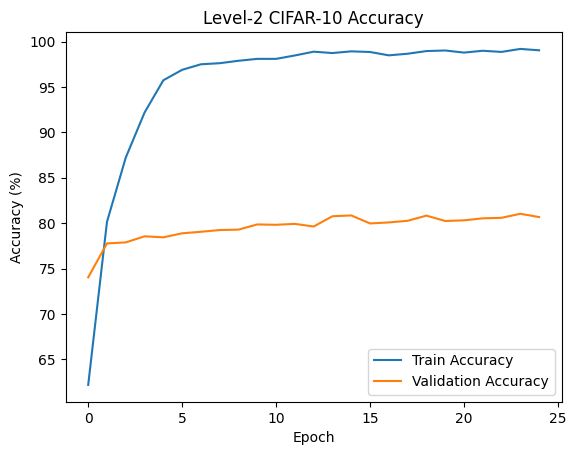

In [10]:
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Level-2 CIFAR-10 Accuracy")
plt.show()


In [11]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")


Final Test Accuracy: 80.86%


Split